# MFHT Rolling Windows PDF Comparison with a ''Stable Window''

We must choose what ''stable'' means.
---
To do: 
1) Only accounts for dates where we must reject the null hypothesis (p-value < 0.05) in favour of the alternative (data were drawn from *different* distributions)
2) Increase the distance between the windows to compare:
    - 28 days *(one month)* ---
    - 3 months *(one quarter, 90 days)*  ---
    - 1 year *(365 days)*  ---
    - 2 years *(500 days)*  ---

In [2]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from tqdm import tqdm
import datetime

import seaborn as sns

from stabilvol.utility import functions as f

DATABASE = '../data/processed/trapezoidal_selection/stabilvol.sqlite'
import os
print(os.getcwd())
os.path.exists(DATABASE)

MARKETS = ["UN", "UW", "LN", "JT"]
START_DATE = "1980-01-01"
END_DATE = "2022-07-01"

START_LEVELS = [-2.0, -1.0, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0, 2.0]
DELTAS = [2.0, 1.0, 0.5, 0.2, 0.1, -0.1, -0.2, -0.5, -1.0, -2.0]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them

NDAYS = 365

G:\UNIPA\ECONOFISICA\stabilizing_volatility\notebooks


In [3]:
def test_mfhts(market, windows, coefficients, metadata):
    """
    Perform a KS-test on the MFHT of one window against that shifted ndays later.
    """
    outcasts = {coeff: [] for coeff in coefficients}
    # Alllocate space for the p-values and statistics values of the KS-test
    p_values = np.zeros((2*len(coefficients), len(windows))) - 1
    stats_values = np.zeros((2*len(coefficients), len(windows))) - 1
    k = 0
    # Load the p-values and statistics values of the KS-test
    for i, (t1_string, t2_string) in enumerate(coefficients):
        for j, window_type in enumerate(['center_max', 'center_min', 'center_crysis']):
            center_window = metadata.loc[df_maxs['thresholds'] == '_'.join([t1_string, t2_string])][window_type]
            center_window = center_window.astype(str).values[0].replace('-', '_')
            print(center_window)
            p_values[k, :] = np.load(f'../data/processed/kstest/{market}_rolling_{center_window}_MFHT_p_{t1_string}_{t2_string}_{VOL_LIMIT}.npy')
            stats_values[k, :] = np.load(f'../data/processed/kstest/{market}_rolling_{center_window}_MFHT_p_{t1_string}_{t2_string}_{VOL_LIMIT}.npy')
            k += 1
    return p_values, stats_values, outcasts


def print_rejections(p_values, windows, ndays, coefficients,):
    # Resample windows
    windows = [windows[i] for i in range(0, len(windows), ndays)]
    # Print the rejection (max 100) 
    for i, (coeff) in enumerate(coefficients):
        max_print = 0
        for j, (start_date, end_date) in enumerate(windows[1:]):
            if max_print > 100:
                break
            if 0.05 >= p_values[i, j] > 0:
                print(f"Reject ({start_date.date()}/{end_date.date()}) p-value {p_values[i, j]}")
                max_print += 1
        print(f"There were {max_print} rejections for {coeff}")

## Rolling Windows

In [4]:
def roll_windows(duration=250,  start_date=None, end_date=None):
    """
    Create rolling windows of a given duration. 
    The windows are shifted by one day.
    """
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    start = start_date + pd.to_timedelta(duration/2, 'D')
    end = end_date - pd.to_timedelta(duration/2, 'D')
    return [(mid - pd.to_timedelta(duration//2, 'D'), mid + pd.to_timedelta(duration//2, 'D')) for mid in pd.date_range(start, end, freq='D')]

In [5]:
# We can take 250 the approximate number of business days in a year
windows = roll_windows(365, start_date=datetime.date(1980, 1, 1), end_date=datetime.date(2022, 7, 1))
len(windows)

15159

In [6]:
# If change this, remember to re-generate all the max_values (regenerate=True)
coefficients = [
    ("m0p5", "m1p5"), 
    # ("0p5", "m1p5"), 
    ("0p5", "1p5"),
    # ("1p0", "3p0"),
]


## Revcover Most-Stable and Least-Stable Windows

In [104]:
def take_extreme_values_window(market, windows, coefficients):
    """
    We take the window with maximum or minimum value of the MFHT for each coefficient.
    """
    
    def extract_window_dates(arg: np.float64) -> tuple:
        window = windows[arg]
        start_date, end_date = window
        center_date = start_date + (end_date - start_date) / 2
        return str(start_date.date()), str(center_date.date()), str(end_date.date())
        
    
    windows_extremes = {'_'.join(coeff): [] for coeff in coefficients}
    max_values = np.zeros(len(windows))
    for i, (t1_string, t2_string) in enumerate(coefficients):
        df = pd.read_pickle(f'../data/processed/dynamics/{market}_rolling_MFHT_peaks_{t1_string}_{t2_string}_200bins_{VOL_LIMIT}.pickle')
        for j, (start_date, end_date) in tqdm(enumerate(windows), desc=market):
            mfht = df[(df['start'] == start_date) & (df['end'] == end_date)]       
            if not mfht.empty:            
                max_values[j] = mfht['mean'].max()
    
        start_max, center_max, end_max = extract_window_dates(max_values.argmax())
        start_min, center_min, end_min = extract_window_dates(max_values.argmin())
    
        # We add manually the crysis center window, September 2008
        windows_extremes['_'.join([t1_string, t2_string])] = [
            start_max, center_max, end_max, start_min, center_min, end_min, '2008-9-01']

    return windows_extremes

In [105]:
# We take only the days after 2011, where we have the most data in every market
best_windows = roll_windows(365, start_date=datetime.date(2011, 1, 1), end_date=datetime.date(2022, 7, 1))
df_rows = []
if os.path.exists(f'../data/processed/dynamics/extremevalues_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.csv'):
    df_maxs = pd.read_csv(f'../data/processed/dynamics/extremevalues_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.csv', parse_dates=True, index_col=0)
else:
    # This takes about 10 minutes
    for market in MARKETS:
        row = take_extreme_values_window(market, best_windows, coefficients)
        df_rows.append(row)
        
    df_maxs = pd.concat([pd.DataFrame.from_dict(row, orient='index') for row in df_rows], keys=MARKETS)
    df_maxs.columns = ['start_max', 'center_max', 'end_max', 'start_min', 'center_min', 'end_min', 'center_crysis']
    df_to_save = df_maxs.reset_index(names=['market', 'thresholds'])
    df_to_save.to_csv(f'../data/processed/dynamics/extremevalues_rolling_MFHT_peaks_variousthresholds_{VOL_LIMIT}.csv', index=False)
    del df_to_save


UN: 3836it [01:00, 63.07it/s]
UN: 3836it [01:01, 62.47it/s]
UW: 3836it [00:56, 67.32it/s]
UW: 3836it [01:00, 62.91it/s]
LN: 3836it [00:44, 85.66it/s]
LN: 3836it [00:51, 75.20it/s]
JT: 3836it [01:01, 62.79it/s]
JT: 3836it [01:00, 63.11it/s]


## UN

In [29]:
market = "UN"

In [39]:
metadata = df_maxs.loc['UN']
p_values, stat_values, outcasts = test_mfhts(market, windows, coefficients, metadata)
actual_windows = windows
# print_rejections(p_values, windows, NDAYS, coefficients) 

1989_06_01
2008_09_01
1989_01_01
2008_09_01


In [40]:
p_values.shape

(4, 15159)

In [41]:
ks_df = pd.DataFrame(p_values.T, index=actual_windows, columns=[f"{market}  {'_'.join(coeff)}" for coeff in coefficients])
ks_df = ks_df.reset_index(drop=False, names=('Window'))
ks_df.head()

ValueError: Shape of passed values is (15159, 4), indices imply (15159, 2)

<Axes: >

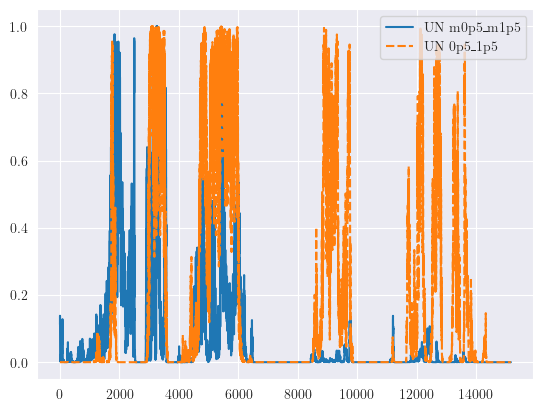

In [42]:
import seaborn as sns

sns.lineplot(data=ks_df.drop('Window', axis=1), palette='tab10')

Outcasts for ('m0p5', 'm1p5'): 0
Outcasts for ('0p5', '1p5'): 0


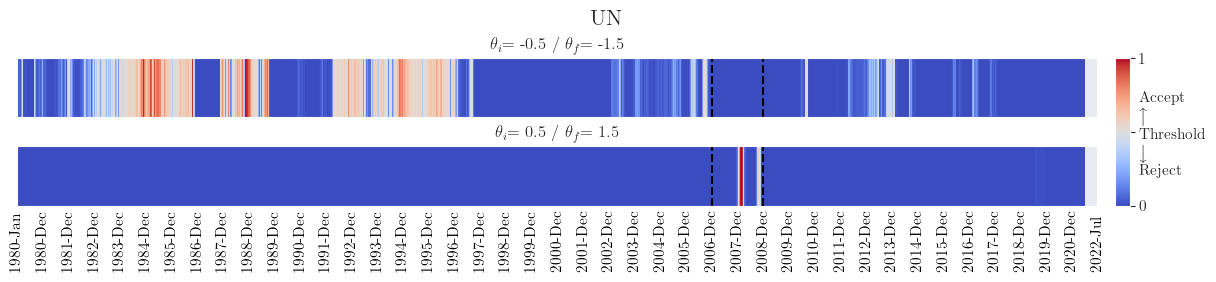

In [43]:
 # With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = f.plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, label_spacing=365)

In [15]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## UW

In [18]:
market = "UW"

In [19]:
metadata = df_maxs[df_maxs['market'] == market]
p_values, stat_values, outcasts = test_mfhts(market, windows, coefficients, metadata)

1986_05_01
1985_01_01


Outcasts for ('m0p5', 'm1p5'): 1055
Outcasts for ('0p5', '1p5'): 14


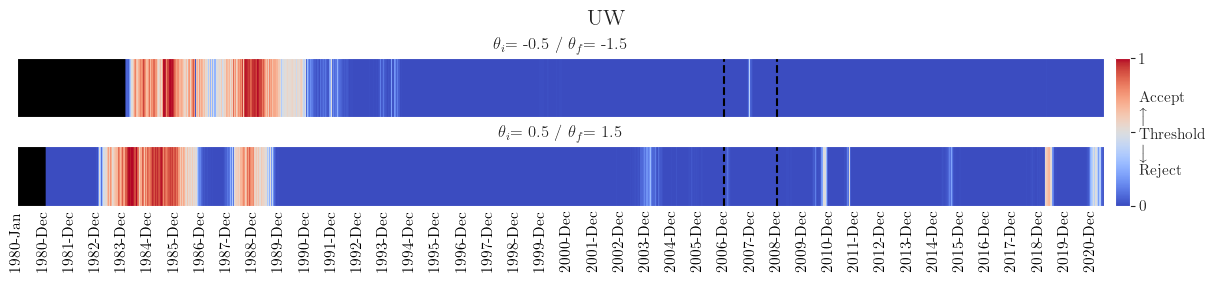

In [20]:
 # With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = f.plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, ndays=NDAYS, label_spacing=365)

In [21]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## LN

In [22]:
market = "LN"

In [23]:
metadata = df_maxs[df_maxs['market'] == market]
p_values, stat_values, outcasts = test_mfhts(market, windows, coefficients, metadata)

1993_10_01
1988_02_01


Outcasts for ('m0p5', 'm1p5'): 3077
Outcasts for ('0p5', '1p5'): 2121


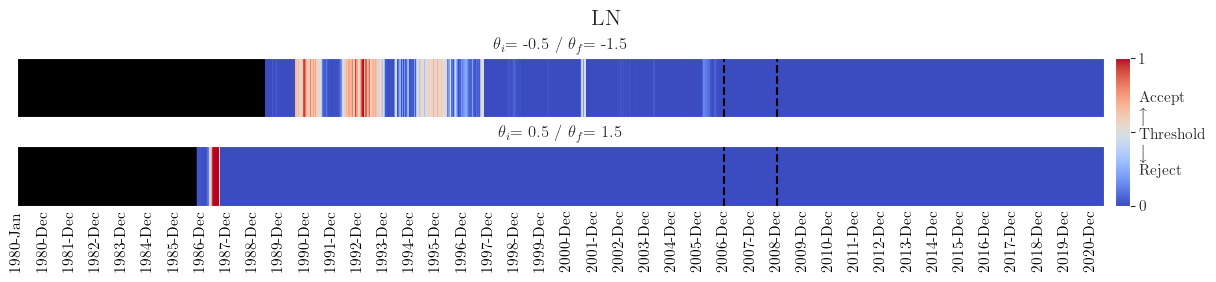

In [24]:
# With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = f.plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, label_spacing=365)

In [25]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')

## JT

In [26]:
market = "JT"

In [27]:
metadata = df_maxs[df_maxs['market'] == market]
p_values, stat_values, outcasts = test_mfhts(market, windows, coefficients, metadata)

1981_12_01
1980_02_01


Outcasts for ('m0p5', 'm1p5'): 0
Outcasts for ('0p5', '1p5'): 15159


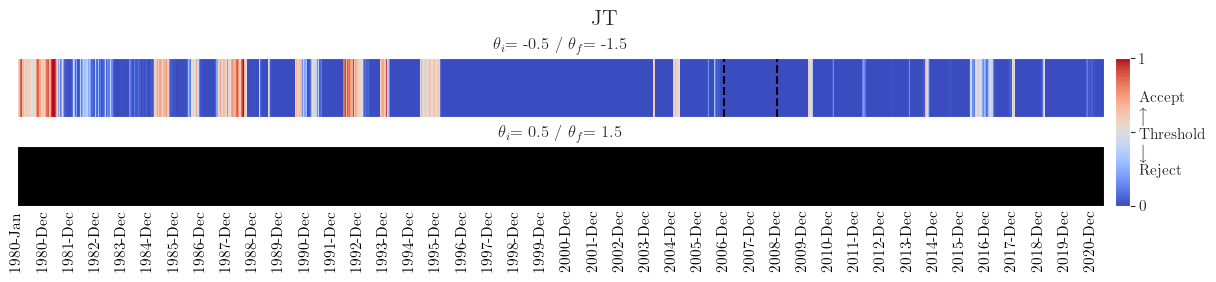

In [28]:
# With a confidence level of 95%, we must reject the hypothesis that the distributions are the same if the p-value is less than 0.05
fig, errors = f.plot_rolling_pmesh(coefficients, actual_windows, p_values, latex=True, suptitle=market, ndays=NDAYS, label_spacing=365)

In [29]:
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.png', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.eps', bbox_inches='tight')
fig.savefig(f'../visualization/dynamics/rolling_windows/{market}_rolling_MFHT_p_variousthresholds_{VOL_LIMIT}.pdf', bbox_inches='tight')